<center> 
<img src="https://upload.wikimedia.org/wikipedia/commons/5/5c/Logo_Mondragon_Unibertsitatea.png" width="150" height="100" float ="left">
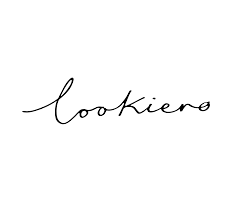    


---
<h3>Beñat Basabe, Jon Jarrín, June Pagaldai, Daniel Puente, Eneko Rentería | <font color='red'> Equipo Rojo<h3>

## Análisis de la cartera - Tendencias de marketing
En este script se detallarán los descriptivos obtenidos de este primer análisis. Tareas como detectar **cantidad de valores missing** o **outliers** entre otros.

### Carga de librerias 
---

- **General**

In [1]:
import pandas as pd
import numpy as np
import glob
import os

- **Pyspark**

In [2]:
import pyspark
from pyspark import SparkContext
from pyspark.sql import SparkSession
from pyspark.sql import SQLContext
from pyspark import SparkFiles
import pyspark.sql.functions as f
from pyspark.sql.functions import lit, trim, split, regexp_replace, when

* **Visualización**

In [ ]:
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import plotly.graph_objs as go
import plotly.express as px
import squarify 

### Clases a utilizar
---

* Clase para **cargar de datos** (cd)

Se fijan los **directorios** de entrada y salida

In [6]:
dir_in, dir_out = "../../datos/datos_originales/", "../../datos/datos_desarrollo/"

spark = SparkSession \
    .builder \
    .appName("how to read csv file") \
    .getOrCreate()

In [7]:
class carga_datos:
    ''' Cargar los datos desde el csv al python:
    - subir_tablas: se suben los dataframes con los titulos deseados. Como input: una lista de dfs y una lista de titulos.
    - subir_una_tabla: como input se especifica la tabla a subir.
    '''
    def __init__(self, dir_in = dir_in):
        self.dir_in = dir_in
        
    def subir_tablas(self, dir_in):
        path = os.getcwd()
        csv_files, dataframes_list = glob.glob(os.path.join(path, dir_in + "*.csv")), []

        for i in csv_files:
            temp_df = spark.read.csv(path = i, header = True, inferSchema = True)
            dataframes_list.append(temp_df)
        
        return dataframes_list
    
    def subir_una_tabla(self, dir_in, nombre_tabla):
        return spark.read.csv(os.path.join(dir_in, nombre_tabla + ".csv"), header = True)

In [8]:
cd = carga_datos ()

### Funciones a utilizar
---

* Para gráficos de barras

In [9]:
def plotear(dataframe, variable, titulo):
    
    total = df.groupby(variable).count().select(variable, 'count').withColumnRenamed('count', 'total').toPandas()
    juntado = total.merge(pd.DataFrame(dataframe[variable].value_counts()).reset_index(), left_on = variable, right_on = 'index').iloc[:, 1:]

    juntado.columns = ['total', variable, 'parte']
    juntado['porcentaje'] = (juntado.parte / juntado.total) * 100
    juntado = juntado.sort_values('porcentaje', ascending = False).reset_index(drop = True)
    
    fig, ax = plt.subplots(figsize = (25,5))

    ax.bar(juntado[variable], juntado.porcentaje, align = 'center', alpha = 0.8, ecolor='black', color = paleta[0])
    ax.set_facecolor('white')
    
    plt.title(titulo, fontweight = 'bold')
    
    plt.xlabel(variable.replace('_', ' ').capitalize())
    plt.ylabel('Porcentaje (%)')
    plt.xticks(rotation = 45)
    plt.show()
    
    
def barras_apiladas(o):
    agrupado = df3.loc[df3.family_product == o, ['tasa_aceptacion', 'ventas']].groupby('tasa_aceptacion').count()
    agrupado /= agrupado.sum()
    return agrupado

* Para el grafo

In [10]:
def make_annotations(pos, text, font_size =8, font_color='rgb(250,250,250)'):
    
    L = len(pos)
    annotations = []
    for k in range(L):
        annotations.append(
            dict(
                text = text[k],
                x = pos[k][0], y = position[k][1],
                xref = 'x1', yref = 'y1',
                font = dict(color = font_color, size = font_size), showarrow = False))
    
    return annotations

### Datos a utlilizar
---

In [11]:
df_envios = cd.subir_una_tabla(dir_in, 'datos_envios_MU')
df_total  = cd.subir_una_tabla(dir_out, 'df_total')

df = df_total.join(df_envios, df_total.id == df_envios.id).drop('id')
df = df.withColumn('id_product', f.concat(f.col('family_product'), lit('_'), f.col('color') , lit('_'), f.col('size_lookiero')))

### Análisis de la cartera de productos
---

* Añadir la paleta de colores a utilizar en los gráficos*

In [12]:
paleta = ['#264653','#2A9D8F','#85CAC2','#DFF6F4' ,'#E9C46A','#F4A261','#E76F51','#C53D1B', '#7E2711']

#### **i) TASA DE ACEPTACIÓN**
---

* Crear la variable *tasa de aceptación*

In [13]:
df = df.withColumn('tasa_aceptacion', df.ventas / df.envios)

* Gráfico general de la tasa de aceptación

In [14]:
df2 = df.toPandas()

variable = 'family_product'

fig = px.box(df2, x = variable, y = 'tasa_aceptacion', color_discrete_sequence = paleta)
fig.update_layout(
    
    title = {'text': '<b>Distribución de la tasa de aceptación</b>',
             'x': .5},
    xaxis_title = variable.replace('_', ' ').capitalize(),
    yaxis_title = "Tasa de aceptación",
    plot_bgcolor = 'rgba(0, 0, 0, 0)',
    paper_bgcolor = 'rgba(0, 0, 0, 0)')

fig.show()

- Preparar el *dataframe*

In [13]:
df3 = df2.copy()
df3['tasa_aceptacion'] = np.where(df3.tasa_aceptacion.between(0,    0.25, inclusive = 'left'), 'muy_poco_aceptado', 
                         np.where(df3.tasa_aceptacion.between(0.25, 0.5,  inclusive = 'left'), 'poco_aceptado',
                         np.where(df3.tasa_aceptacion.between(0.5,  0.75, inclusive = 'left'),  'aceptado', 'muy_aceptado')))    

apilado = pd.concat(list(map(barras_apiladas, df2.family_product.unique())), axis = 1)
apilado.columns = df2.family_product.unique()
apilado = apilado.reindex(['muy_poco_aceptado', 'poco_aceptado', 'aceptado', 'muy_aceptado'])

- Plotear

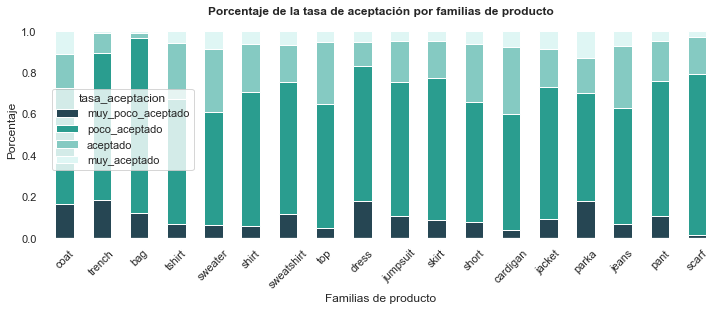

In [14]:
sns.set(rc = {"figure.figsize": (12, 4), 'axes.facecolor':'white', 'figure.facecolor':'white'})
apilado.T.plot(kind = 'bar', stacked = True, color = paleta)
plt.title('Porcentaje de la tasa de aceptación por familias de producto', fontweight = 'bold')
plt.xlabel('Familias de producto')
plt.ylabel('Porcentaje')
plt.xticks(rotation = 45)

plt.show();

- Preparar *dataframe*

In [14]:
df4 = df2.copy()
df4[['envios', 'ventas']] = df4[['envios', 'ventas']].astype('float')
df5 = df4.groupby('family_product')[['envios', 'ventas']].sum()

- Plotear

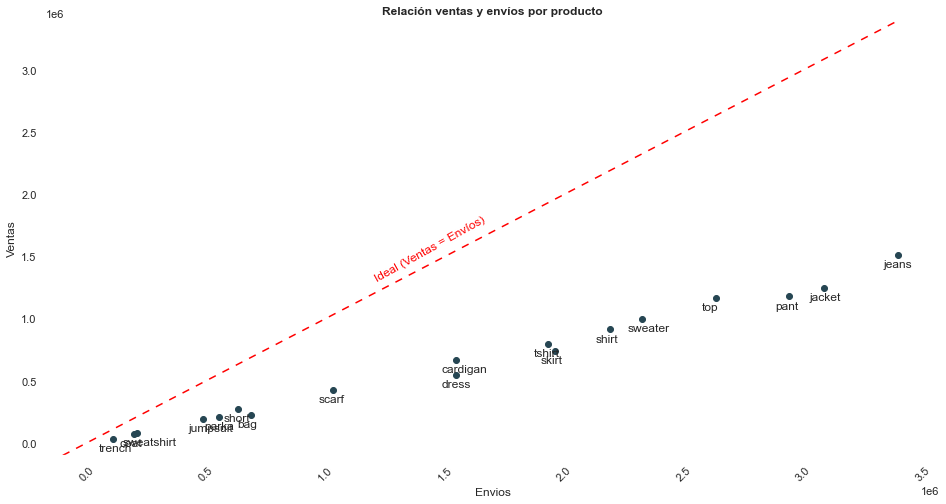

In [15]:
fig, ax = plt.subplots(figsize = (16, 8))

ax.scatter(df5.envios, df5.ventas,  color = paleta[0])
ax.set_facecolor('white')
ax.axline((0, 0.5), slope = 1, color = 'red', linestyle = (0, (5, 5)))
for i, e, v in zip(df5.index, df5.envios, df5.ventas): ax.annotate(i, (e - 59999, v - 98999))

ax.annotate('Ideal (Ventas = Envíos)', (1.2e6, 1.3e6), color = 'red', rotation = 29)
plt.title('Relación ventas y envíos por producto', fontweight = 'bold')

plt.xlabel('Envios')
plt.ylabel('Ventas')
plt.ylim(-99999, max(max(df5.envios), max(df5.ventas)))
plt.xticks(rotation = 45)
plt.show()

* Preparar *dataframe*

In [20]:
var1, var2 = 'family_product', 'size_lookiero'
heat = pd.pivot_table(df2[[var1, var2, 'tasa_aceptacion']], values = 'tasa_aceptacion', index = [var1], 
               columns = [var2], fill_value = 0)

heat = heat.reindex(columns = ['UNQ', 'XXS', 'XS', 'S', 'M', 'L', 'XL', 'XXL', 'XXXL', 'X4XL'])

* Plotear

In [24]:
list(heat.columns)

['UNQ', 'XXS', 'XS', 'S', 'M', 'L', 'XL', 'XXL', 'XXXL', 'X4XL']

In [61]:
lista = [list(heat.iloc[x,:].values) for x in  range(len(heat)-1, -1, -1)]

In [93]:
bb = pd.DataFrame(lista).T
bb.columns = heat.index

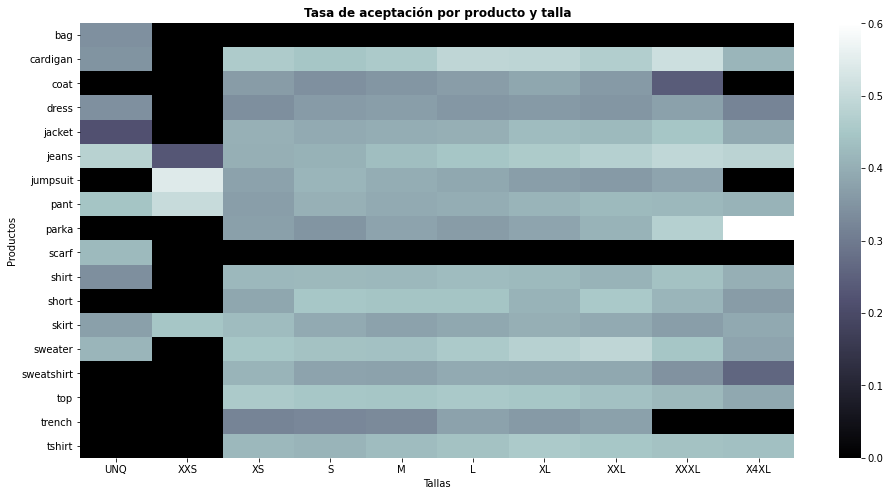

In [21]:
fig, ax = plt.subplots(figsize = (16, 8))
ax = sns.heatmap(heat, cmap = 'bone')
ax.set_xlabel('Tallas')
ax.set_ylabel('Productos')
ax.set_title(f"Tasa de aceptación por producto y talla", fontweight = 'bold');

**1) MUY ACEPTADOS**

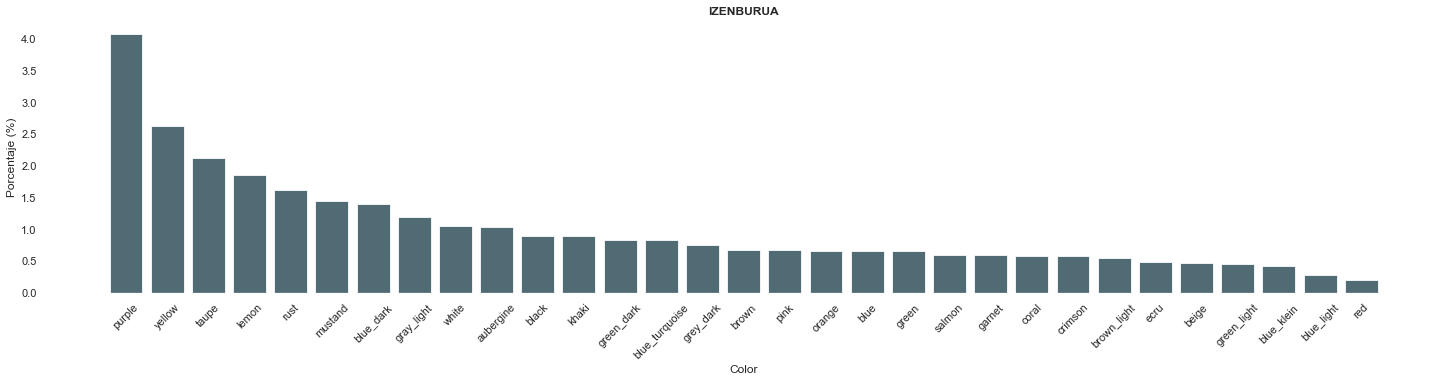

In [18]:
top = df.filter(df.tasa_aceptacion == 1.0).toPandas()
plotear(top, 'color', 'IZENBURUA')

**2) NUNCA ACEPTADOS**

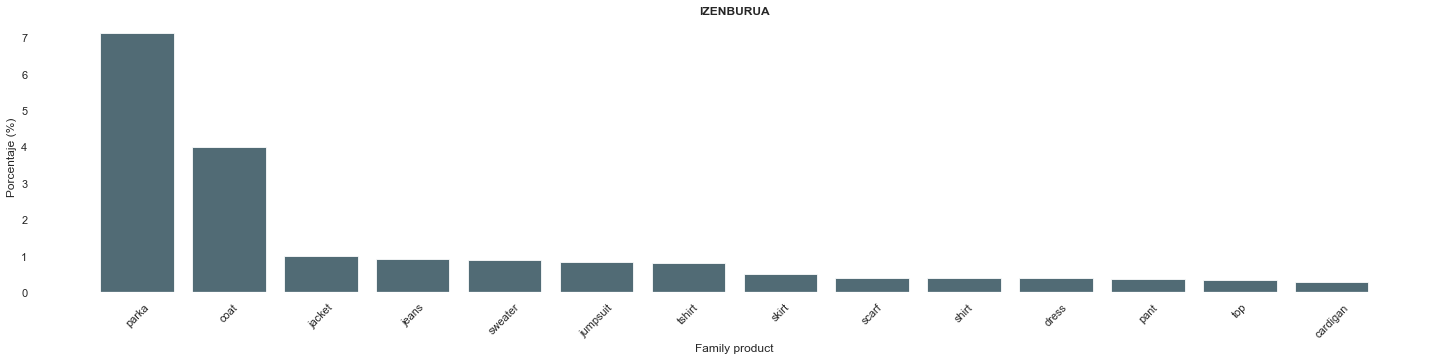

In [19]:
bottom = df.filter(df.tasa_aceptacion == 0.0).toPandas()
plotear(bottom, 'family_product', 'IZENBURUA')

---

---

**3) NUNCA ENVIADOS**

- Preparar el dataframe

In [15]:
nunca_enviados = df.where(f.col('tasa_aceptacion').isNull())
prod_no_enviados = [e[0] for e in nunca_enviados.select('family_product').distinct().collect()]

total = df.filter((df.family_product).isin(prod_no_enviados)).groupby('family_product').count().select('family_product', 'count').withColumnRenamed('count', 'total')
no_env = nunca_enviados.groupby('family_product').count().select('family_product', 'count').withColumnRenamed('count', 'no_enviados').withColumnRenamed('family_product', 'borrar')

a = total.join(no_env, total.family_product == no_env.borrar).drop('borrar')
a = a.withColumn('porcentaje', (a.no_enviados / a.total) * 100).toPandas()

- Plotear

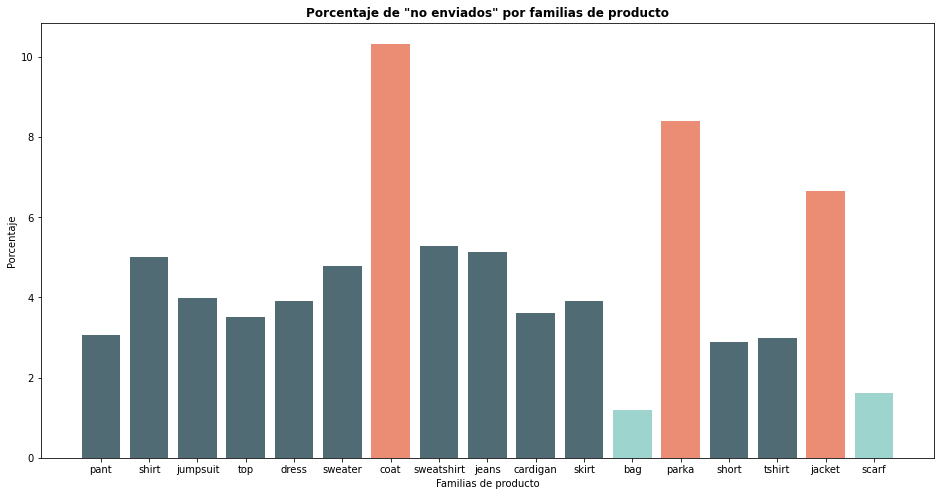

In [16]:
alto, normal, bajo = [paleta[6]], [paleta[0]], [paleta[2]]
colores = normal * 6 + alto + normal * 4 + bajo + alto + normal * 2 + alto + bajo

fig, ax = plt.subplots(figsize = (16, 8))

ax.bar(a.family_product, a.porcentaje, align = 'center', alpha = 0.8, ecolor='black', color = colores)
ax.set_facecolor('white')
plt.title('Porcentaje de "no enviados" por familias de producto', fontweight = 'bold')
plt.xlabel('Familias de producto')
plt.ylabel('Porcentaje')
plt.show()

### 3 productos no enviados, más frecuentes

In [ ]:
coat=nunca_enviados[nunca_enviados['family_product']=='coat']
parka=nunca_enviados[nunca_enviados['family_product']=='parka']
jacket=nunca_enviados[nunca_enviados['family_product']=='jacket']

* Preparar el *dataframe*

In [ ]:
coat=coat[coat['color'].isin(['green','crimson','gray_light'])]
Lista=[100,23.08,100]
Colores=['Carmesí','Gris claro','Verde']
coat=coat.groupby(by=["color"]).count()
coat=coat[['size_lookiero']]
coat=coat.reset_index()
coat['Porcentaje']=Lista
coat = coat.rename(columns={'color': 'Color', 'size_lookiero': 'Frecuencia'})
coat['Color']=Colores

* Plotear

In [ ]:
fig = px.bar(coat, x="Color", y="Porcentaje",color='Color', text="Frecuencia",title="El porcentaje de devoluciones por color en coat",color_discrete_sequence =['#6C211D','#D3D3D3','#35B850'])
fig.update_layout(paper_bgcolor="White",plot_bgcolor='white')
fig.show()

* Preparar *dataframe*

In [ ]:
parka=parka[parka['color'].isin(['grey','yellow','green_dark'])]
parka=parka.groupby(by=["color"]).count()
parka=parka[['size_lookiero']]
parka=parka.reset_index()
parka['Porcentaje']=[17.91,50,21.43]
Colores_parka=['Verde oscuro','Gris','Amarillo']
parka = parka.rename(columns={'color': 'Color', 'size_lookiero': 'Frecuencia'})
parka['Color']=Colores_parka

* Plotear

In [ ]:
fig = px.bar(parka, x="Color", y="Porcentaje",color='Color', text="Frecuencia",title="El porcentaje de devoluciones por color en parka",color_discrete_sequence =['#1c542d','#808080','#FFFF00'])
fig.update_layout(paper_bgcolor="White",plot_bgcolor='white')
fig.show()

* Preparar *dataframe*

In [ ]:
jacket=jacket[jacket['color'].isin(['silver','gold','salmon','brick','camel'])]
jacket=jacket.groupby(by=["color"]).count()
jacket=jacket[['size_lookiero']]
jacket=jacket.reset_index()
jacket['Porcentaje']=[50,27.5,100,88.89,100]
Colores_jacket=['Brick','Beige','Oro','Salmon','Plata']
jacket = jacket.rename(columns={'color': 'Color', 'size_lookiero': 'Frecuencia'})
jacket['Color']=Colores_jacket

* Plotear

In [ ]:
fig = px.bar(jacket, x="Color", y="Porcentaje", text="Frecuencia",color='Color',title="El porcentaje de devoluciones por color en jacket",color_discrete_sequence =['#dc5539','#724625','#EABE3F','#F28773','#C0C0C0'])
fig.update_layout(paper_bgcolor="White",plot_bgcolor='white')
fig.show()

#### **ii) CONTRIBUCIÓN A VENTAS**
---

* Preparar *dataframe*

In [23]:
variable = 'origin_brand'
df2[['envios', 'ventas']] = df2[['envios', 'ventas']].astype('float')
treemap = df2.groupby(variable)[['envios']].sum() / df2.groupby(variable)[['envios']].sum().sum()

* Plotear

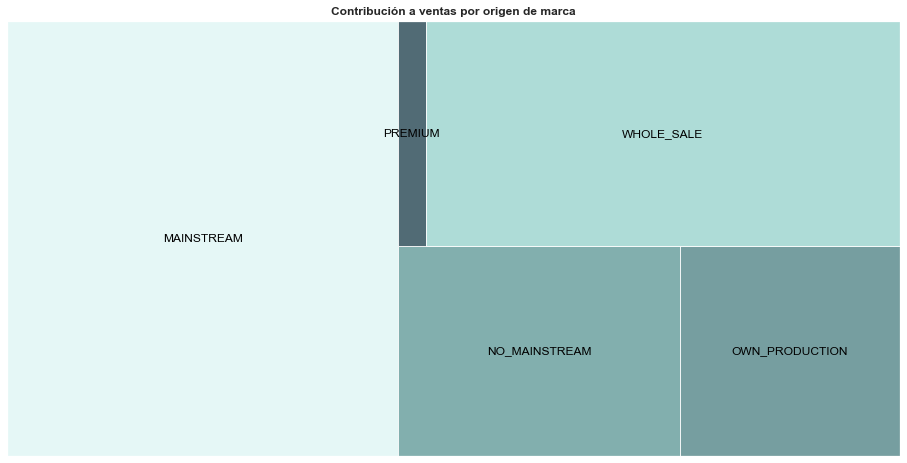

In [24]:
cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", [paleta[0], paleta[2], paleta[3]])
norm = matplotlib.colors.Normalize(vmin = min(treemap.envios), vmax = max(treemap.envios))
colors = [cmap(norm(value)) for value in treemap.envios]

fig, ax = plt.subplots(figsize = (16, 8))
squarify.plot(sizes = treemap.envios, label = treemap.index, alpha = .8, color = colors, text_kwargs = {'color': 'black'})
plt.title('Contribución a ventas por origen de marca', fontweight = 'bold')
plt.xticks([])
plt.yticks([])
plt.show()

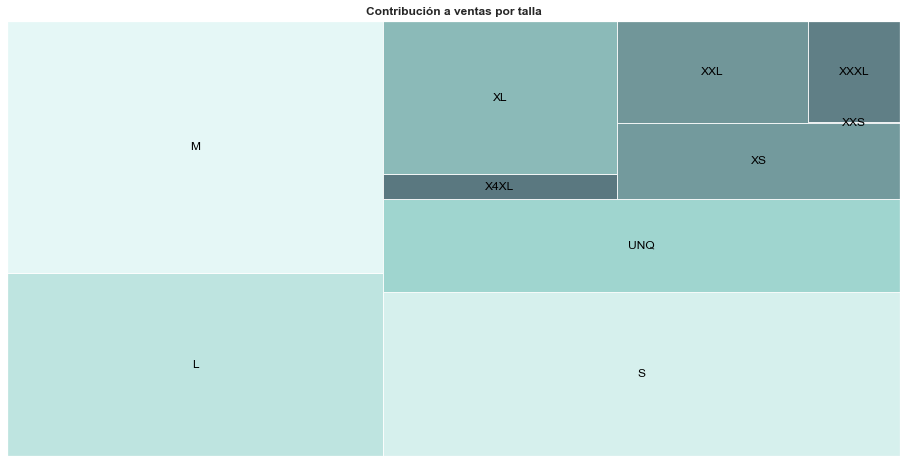

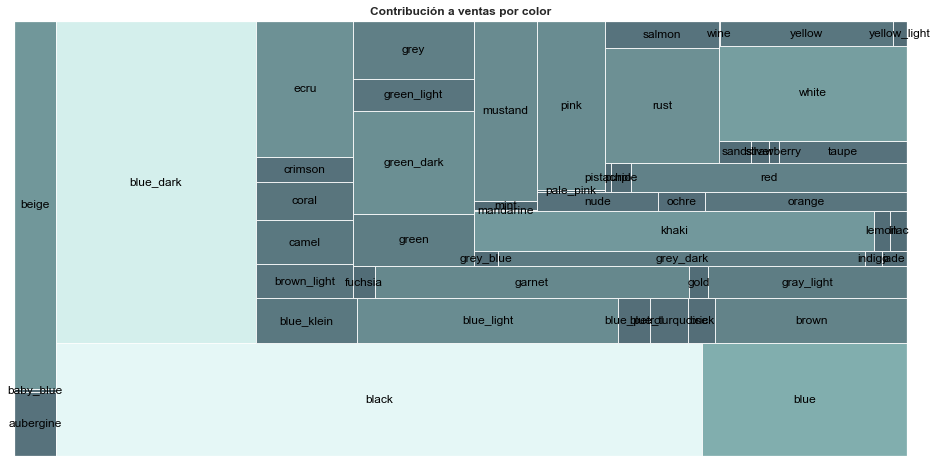

#### **iii) AMPLITUD, LONGITUD Y PROFUNDIDAD**
---

Se define como línea los niveles 1 (cuerpo entero + tronco inferior), 2 (tronco superior) y 3 (abrigos + complementos). Mientras que las categorías serán los subniveles 1.1 (cuerpo entero), 1.2 (solo parte de abajo), etc.

**Línea 1:** Cuerpo entero + tronco inferior  
- **Categoría 1.1:** Cuerpo entero  
- **Categoría 1.2:** Tronco inferior  

**Línea 2:** Tronco superior  
- **Categoría 2.1:** Nikis  
- **Categoría 2.2:** Jerseys  
    
**Línea 3:** Abrigos + complementos  
- **Categoría 3.1:** Abrigos  
- **Categoría 3.2:** Complementos  

In [13]:
niveles = {'jumpsuit': '1.1', 
           'dress': '1.1',
           
           'jeans': '1.2',
           'skirt': '1.2',
           'short': '1.2',
           'pant': '1.2',
          
           'shirt': '2.1',
           'top': '2.1',
           'tshirt': '2.1',
          
           'sweater': '2.2',
           'sweatshirt': '2.2',
           'cardigan': '2.2',
          
           'trench': '3.1',
           'coat': '3.1',
           'parka': '3.1',
           'jacket': '3.1',
          
           'bag': '3.2',
           'scarf': '3.2'}

df = df.withColumn('categoria', df['family_product'])
df = df.na.replace(niveles, 'categoria')
df = df.withColumn('linea', df.categoria.substr(0, 1))

df2 = df.toPandas()

df2.linea = df2.categoria
df2.categoria = np.where(df2.categoria == '3.2', 'complementos', 'prendas')

lineas = {
    '1.1': 'tronco_entero',
    '1.2': 'tronco_inferior',
    '2.1': 'tronco_superior_interior',
    '2.2': 'tronco_superior_interior',
    '3.1': 'tronco_superior_exterior',
    '3.2': 'complementos'
}
df2.linea = df2.linea.map(lineas)

df2.loc[df2.id_product.str.split('_').str[0] == 'bag', 'linea'] = 'mochila'
df2.loc[df2.id_product.str.split('_').str[0] == 'scarf', 'linea'] = 'bufanda'

C:\ProgramData\Anaconda3\lib\site-packages\pyspark\sql\dataframe.py:2233: UserWarning:

to_replace is a dict and value is not None. value will be ignored.



**1) AMPLITUD**

In [77]:
import igraph
from igraph import Graph, EdgeSeq
import plotly.graph_objects as go

nr_vertices = 9
v_label = list(map(str, range(nr_vertices)))
G = Graph.Tree(nr_vertices, 2)

position = {0: [0.65, 10.0],
            1: [-.75, 8.],
            2: [1.5,  8.],
            3: [-1.9, 4.0],
            4: [-1.2, 4.0],
            5: [-0.6, 4.0],
            6: [0.0,  4.0],
            7: [1.0,  4.0],
            8: [2.0,  4.0]}

Y = [position[k][1] for k in range(nr_vertices)]
M = max(Y)
E = [(0, 1), (0, 2), (1, 3), (1, 4), (1, 5), (1, 6), (2, 7), (2, 8)]

L = len(position)
Xn = [position[k][0] for k in range(L)]
Yn = [position[k][1] for k in range(L)]
Xe = []
Ye = []
for edge in E:
    Xe += [position[edge[0]][0], position[edge[1]][0], None]
    Ye += [position[edge[0]][1], position[edge[1]][1], None]

labels = v_label

In [89]:
nombres = ['Lookiero', 'Prendas', 'Complemento',
           'Cuerpo entero', 'Tronco inferior',
           'Superior interior', 'Superior exterior',
           'Mochilas', 'Bufandas']

categoria_size = list(pd.Series([2012, 6579, 11380, 3548, 168, 248]) / 
                      sum(pd.Series([2012, 6579, 11380, 3548, 168, 248])) * 100)
linea_size = list(df2.categoria.value_counts() / sum(df2.categoria.value_counts()) * 100)

size2 = [100] + linea_size + categoria_size
size = [size2[0]] + [e + 60 for e in size2[1:]]

In [93]:
colores = ['#264653', '#3b5864', '#516a75', '#7c9097',
           '#7c9097', '#3b5864', '#a8b5ba', '#d3dadc', '#d3dadc']

fig = go.Figure()
fig.add_trace(go.Scatter(x = Xe,
                   y = Ye,
                   mode = 'lines',
                   line = dict(color = 'rgb(210, 210, 210)', width = 1),
                   hoverinfo = 'none'
                   ))
fig.add_trace(go.Scatter(x = Xn,
                  y = Yn,
                  mode = 'markers',
                  name = 'bla',
                  marker = dict(symbol = 'circle-dot',
                                size = size,
                                color = colores,
                                line = dict(color = 'rgb(38, 70, 83)', width = 1)),
                  text = nombres,
                  hoverinfo = 'text',
                  opacity = 1
                  ))

axis = dict(showline = False, zeroline = False, showgrid = False, showticklabels = False)

fig.update_layout(title = 'Categorías y líneas de Lookiero',
              annotations = make_annotations(position, nombres),
              font_size = 12,
              showlegend = False,
              xaxis = axis,
              yaxis = axis,
              margin = dict(l = 40, r = 40, b = 85, t = 100),
              hovermode = 'closest',
              plot_bgcolor = 'rgb(255, 255, 255)')
fig.show()

**2) LONGITUD**

In [150]:
print(f'La empresa Lookiero trata con {df2.name_brand.nunique()} marcas diferentes')

La empresa Lookiero trata con 163 marcas diferentes


**3) PROFUNDIDAD**

In [146]:
print(f'La empresa Lookiero trata con {df2.id_product.nunique()} productos de diferentes versiones')

La empresa Lookiero trata con 3351 productos de diferentes versiones


- Amplitud: Cantidad de líneas que maneja una compañía
- Longitud: Total de las marcas existentes en una compañía
- Profundidad: Cantidad de versiones de cada producto que se llegan a ofrecer dentro de una linea

---